In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from scipy.spatial import distance
import cv2
from skimage.restoration import denoise_tv_chambolle
import matplotlib.patheffects as pe
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion
from scipy.stats import gaussian_kde

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-10-16 14:56:08.587116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 14:56:08.587153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 14:56:08.588296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 14:56:08.693710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-16 14:56:11.105592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-16 14:56:11.127821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-16 14:56:11.127864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
model_num = 24

In [3]:
N = 10
T = 200
L = None

WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 2

In [4]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [5]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        vals = []
        for checkpoint in range(win_widths[-1]//2, len(x_pos) - win_widths[-1]//2):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 #/ win_width
            xs2 = xs2 #/ win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 #/ win_width 
            ys2 = ys2 #/ win_width
            
            """
            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))
            """
            vals.append( abs(xs1[-1] - xs2[-1]) + abs(ys1[-1] - ys2[-1]) )
            #        * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
            #                 * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.array(vals) / 2.
        all_vals.append(vals)
    return np.array(all_vals)

In [6]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [7]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        if crop.shape[1] != shift_width:
            crop = np.hstack((crop, np.zeros((crop.shape[0], shift_width - crop.shape[1])) ))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [8]:
def merge_close_points(changepoints, signal, pred_probas, seuil=5):
    seq_sums = []
    val_orders = np.argsort(np.sum(signal[:, changepoints], axis=0))[::-1]
    #val_orders = np.argsort(pred_probas)[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [9]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(data.shape[0], ext_width), shift_width)

    return (signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
            norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

In [10]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [11]:
def press_cp(cps, jump_d):
    filtered_cps = []
    if len(cps) == 0:
        return []
    if len(cps) == 1:
        return cps
    
    for i in range(len(cps)):
        if i == 0:
            if cps[i] + jump_d == cps[i+1]:
                filtered_cps.append(cps[i])
        elif i == len(cps) - 1:
            if cps[i] - jump_d == cps[i-1]:
                filtered_cps.append(cps[i])
        else:
            if cps[i] == cps[i-1] + jump_d or cps[i] == cps[i+1] - jump_d:
                filtered_cps.append(cps[i])
    return np.array(filtered_cps)
    

In [12]:
def slice_sum_divide(slices, jump_d, shift_width):
    slice_d = []
    for i in range(0, slices.shape[0], jump_d):
        crop = slices[i - shift_width//2: i + shift_width//2]
        if i <= shift_width//2:
            crop = np.hstack((np.zeros((shift_width - crop.shape[0])), crop))
        elif i >= slices.shape[0] - shift_width//2:
            crop = np.hstack((crop, np.zeros((shift_width - crop.shape[0]))))
        slice_d.append(crop)
    return np.array(slice_d)

In [13]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    cps_before_reg = []
    if x.shape[0] <  win_widths[0]:
        return cps
    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1]//2,
                                                                                       jump_d,
                                                                                      SHIFT_WIDTH)
    #signal, norm_signal = make_signal(x, y, win_widths)
    #input_signals, indice = slice_data(signal, jump_d=jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        pred_org = pred.copy()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.5]
        cps_before_reg = cps.copy()

        if check_proba:
            for k, i in enumerate(range(0, x.shape[0], jump_d)):
                print(np.round(pred[k], 3), i, end='     ')
            print()
            

    if len(cps) == 0:
        return cps, cps_before_reg, np.round(pred_org, 3)

    reg_inputs = input_signals[cps//jump_d,:,:,:]
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()

    if check_proba:
        print(np.hstack((cps, reg_outputs)).reshape(-1, 2))
    
    app_indice = np.argwhere(abs(reg_outputs) < jump_d*2).flatten()
    cps = cps[app_indice]
    reg_outputs = reg_outputs[app_indice]
    cps = np.round(cps + reg_outputs).astype(int)

    input_signals = []
    indices = []
    cps_doublecheck = []

    for cp_check in cps:
        if cp_check <= 0 or cp_check >= x.shape[0]:
            continue
        indices.append(cp_check)
        input_signals.append(ext_signal[:, min(x.shape[0], win_widths[-1]//2) + cp_check - SHIFT_WIDTH//2:
                              min(x.shape[0], win_widths[-1]//2) + cp_check + SHIFT_WIDTH//2])

    if len(indices) == 0:
        return [], np.sort(cps_before_reg), np.round(pred_org, 3)
        
    input_signals = np.array(input_signals)
    input_signals = input_signals.reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps_doublecheck = np.array(indices)[np.argwhere(pred >= 0.5).flatten()]
        pred_probas = pred[np.argwhere(pred >= 0.5).flatten()]
        
    if len(cps_doublecheck) > 0:
        cps_doublecheck = merge_close_points(np.array(cps_doublecheck), signal, pred_probas, seuil=3)
    return np.sort(cps_doublecheck), np.sort(cps_before_reg), np.round(pred_org, 3)

In [17]:
classification_model = tf.keras.models.load_model(f'./models/{model_num}/cls_model_{SHIFT_WIDTH}_2.keras')
regression_model = tf.keras.models.load_model(f'./models/{model_num}/reg_model_{SHIFT_WIDTH}_2.keras')

In [2]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 5
fovs = [0]
traj_idx = [0] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
checkpoints = [0]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        print('Trajectory legnth: ', x.shape)
        # Assign one changepoints for each traj at 0.25 of its length

        cps,pred_p = ana_cp_predict2(classification_model,
                                      x,
                                      y,
                                      WINDOW_WIDTHS,
                                      JUMP_D,
                                      SHIFT_WIDTH,
                                      True)
        #cps_before_reg = np.setdiff1d(cps_before_reg, [x for x in np.concatenate((np.arange(3), np.arange(length_traj-3, length_traj)))])
        #print(cps_before_reg)
        
        print(f'CPS: {cps}')
        
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y, 
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  JUMP_D,
                                                                                  SHIFT_WIDTH)
        
        plt.figure(figsize=(8, 8))
        plt.plot(x, y, linewidth=0.8)
        plt.xlim([np.min(x) - 25,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        plt.ylim([np.min(y) - 25,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        for checkpoint in checkpoints:
            plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')
        
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')
        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
        for cp in cps:
            ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], c='red', alpha=0.6)

        ax.set_xlim([np.min(x) - 10,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.set_ylim([np.min(y) - 10,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
        ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
        for checkpoint in checkpoints:
            ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

        plt.figure()
        for i in range(signals.shape[0]):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.2,
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])
        plt.scatter(cps, np.array([np.max(signals) + 1] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(signals)] * len(cps_before_reg)), c='red')
        plt.ylim([0, max(10, np.max(signals)) + 2])
        
        plt.figure()
        for i in range(norm_signals.shape[0]):
            plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.2, 
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
        comp_signal = compress_signals(norm_signals)
        #plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')
        #plt.plot(np.arange(signals.shape[1]), comp_signal, c='black')
        plt.scatter(cps, np.array([np.max(comp_signal) + 0.2] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(comp_signal) + 0.1] * len(cps_before_reg)), c='red')
        plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')
        
        
        
        
 
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  10)
        cps = press_cp(cps, JUMP_D)
        slice_sum = np.sum(sliced_signals, axis=(1, 2))

        slice_sum /= np.max(slice_sum)
        plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
        print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
        print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
        merged_cps = list(map(climb_mountain,
                              [slice_sum] * len(cps),
                              cps,
                             [5 * JUMP_D ] * len(cps)))
        merged_cps = np.sort(np.unique(merged_cps))
        if -1 in merged_cps:
            merged_cps = np.delete(merged_cps, 0)
        plt.scatter(merged_cps, np.array([np.max(slice_sum) + 0.2] * len(merged_cps)), c='black')
        for idx, mer_cp in enumerate(merged_cps):
            merged_cps[idx] = cps[np.argmin(abs(cp - float(mer_cp)))]

        
        reg_inputs = []
        for merged_cp in merged_cps:
            xx = signals[:, max(0, -SHIFT_WIDTH//2 + merged_cp) : min(signals.shape[1], SHIFT_WIDTH//2 + merged_cp)]
            if merged_cp < SHIFT_WIDTH//2:
                xx = np.hstack((np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1])), xx))
            elif merged_cp > signals.shape[1] - SHIFT_WIDTH//2:
                xx = np.hstack((xx, np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1]))))             
            reg_inputs.append(xx)
        reg_inputs = np.array(reg_inputs).reshape(-1, signals.shape[0], SHIFT_WIDTH, 1)
        if reg_inputs.shape[0] != 0:
            reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
            final_cps = np.round(merged_cps + reg_outputs).astype(int)
            final_cps = merge_close_points(final_cps, signals, None, seuil=3)
            plt.scatter(final_cps, np.array([np.max(slice_sum) + 0.25] * len(final_cps)), c='orange')
            for aa in final_cps:
                ax.scatter3D(x[aa], y[aa], np.arange(signals.shape[1])[aa], marker='+', c='blue', alpha=0.7)

        

    

Trajectory legnth:  (32,)


NameError: name 'ana_cp_predict2' is not defined

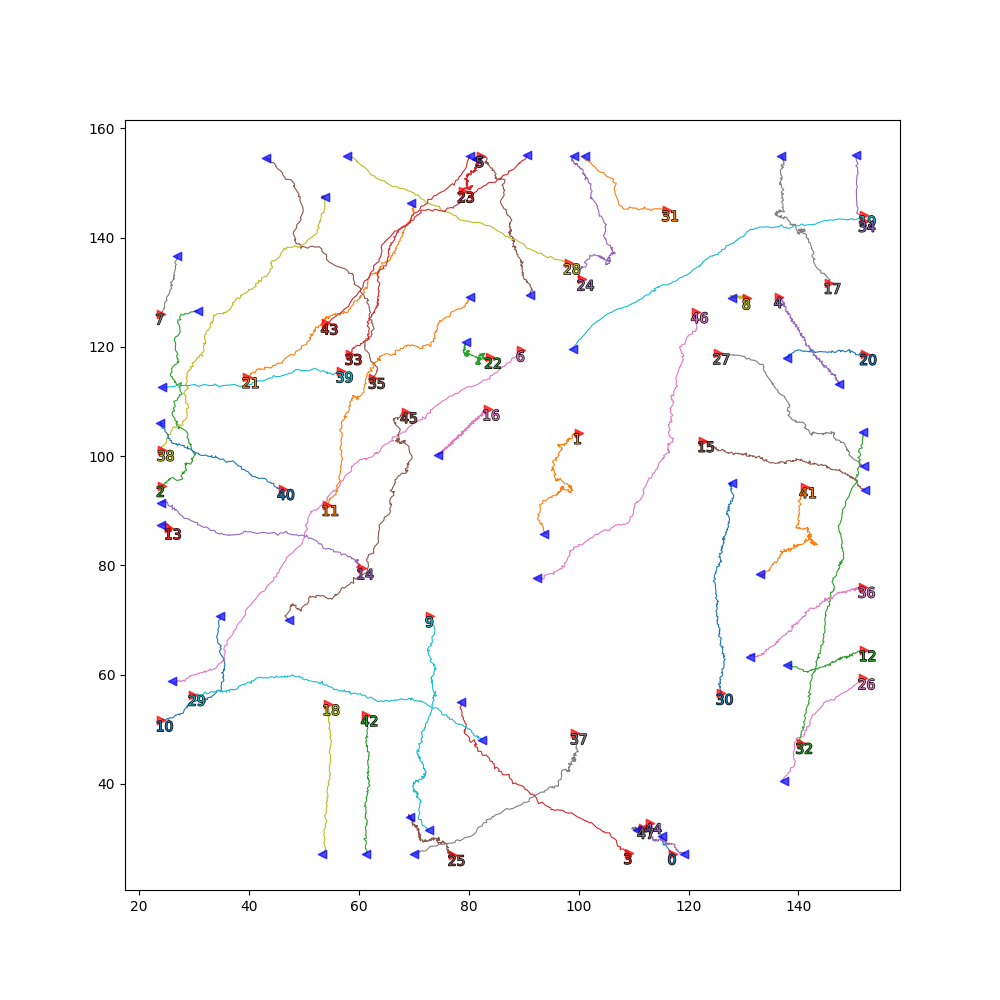

In [4]:
track = 2
exp = 8
fovs = [0]
check_indice = [0, 50]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
    plt.figure(figsize=(10, 10))
    for idx in np.unique(df.traj_idx).astype(int)[check_indice[0]: check_indice[1]]:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        #cps, _ = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)

        trajectory = plt.plot(x, y, linewidth=0.8, zorder=0)
        plt.scatter(x[0], y[0], marker='>', c='red', zorder=1, alpha=0.7)
        plt.annotate(str(idx), xy=(x[0]-1,y[0]-2), color=trajectory[0].get_color(), path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.scatter(x[-1], y[-1], marker='<', c='blue', zorder=1, alpha=0.7)
        #for cp in cps:
        #    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2) 


# Produce a trajectory and check signals

In [264]:
def ana_cp_predict2(model, x, y, win_widths, jump_d, shift_width, check_proba=False):
    cps = []
    if x.shape[0] < win_widths[0]:
        return cps

    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1] // 2,
                                                                                       jump_d,
                                                                                       shift_width)

    _, _, sliced_signals, _, _ = signal_from_extended_data(x, y,
                                                           win_widths,
                                                           win_widths[-1] // 2,
                                                           1,
                                                           10)

    slice_sum = np.sum(sliced_signals, axis=(1, 2))
    slice_sum /= np.max(slice_sum)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1) ** 2 / np.std(signal, axis=1) ** 2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    input_slice_sum = slice_sum_divide(slice_sum, jump_d, shift_width).reshape(-1, 1, SHIFT_WIDTH, 1)
    input_slice_snr = np.array([np.mean(slice_sum)**2 / np.std(slice_sum)**2] * input_slice_sum.shape[0])


    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1, input_slice_sum, input_slice_snr], verbose=0).flatten()
        cps = indice[pred >= 0.5]

    cps = press_cp(cps, jump_d)
    if len(cps) == 0:
        return cps, pred



    merged_cps = list(map(climb_mountain,
                          [slice_sum] * len(cps),
                          cps,
                          [5 * jump_d] * len(cps)))
    merged_cps = np.sort(np.unique(merged_cps))
    if -1 in merged_cps:
        merged_cps = np.delete(merged_cps, 0)
    for idx, mer_cp in enumerate(merged_cps):
        merged_cps[idx] = cps[np.argmin(abs(cps - float(mer_cp)))]

    reg_inputs = []
    for merged_cp in merged_cps:
        xx = signal[:, max(0, -shift_width//2 + merged_cp) : min(signal.shape[1], shift_width//2 + merged_cp)]
        if merged_cp < shift_width//2:
            xx = np.hstack((np.zeros((xx.shape[0], shift_width - xx.shape[1])), xx))
        elif merged_cp > signal.shape[1] - shift_width//2:
            xx = np.hstack((xx, np.zeros((xx.shape[0], shift_width - xx.shape[1]))))
        reg_inputs.append(xx)
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], shift_width, 1)

    if len(merged_cps) != 0:
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        final_cps = np.round(merged_cps + reg_outputs).astype(int)
        final_cps = merge_close_points(final_cps, signal, None, seuil=3)
        return np.sort(final_cps), pred
    else:
        return [], pred

In [8]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=200,
                                                        alphas=[1.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[1.0, 0.0], [0.0, 1.0]]
                                                       )

In [9]:
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
cps,pred_p = ana_cp_predict2(classification_model,
                              trajs_model[:, 0, 0],
                              trajs_model[:, 0, 1],
                              WINDOW_WIDTHS,
                              JUMP_D,
                              SHIFT_WIDTH,
                              True)

changepoints = changepoints[:-1]
print(f'GT: {changepoints}')
print(f'Pred: {cps}')

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals, _ , _ , _ = signal_from_extended_data(x, y,
                                                             WINDOW_WIDTHS,
                                                             WINDOW_WIDTHS[-1]//2,
                                                             JUMP_D,
                                                             SHIFT_WIDTH)
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in cps:
    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in cps:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='red', zorder=2)
for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)

plt.figure()
plt.ylim([0, max(10, np.max(signals)) + 2])
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='blue')

for cp in cps:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='red')

        
plt.figure()
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

for cp in cps:
    plt.vlines(cp, 0, 1, color='red')

plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')


signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  5)

slice_sum = np.sum(sliced_signals, axis=(1, 2))
slice_sum -= np.min(slice_sum)
slice_sum /= np.max(slice_sum)

plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
print(f'slice_sum_SNR: {1 / (np.mean(slice_sum)**2 * np.std(slice_sum)**2)}')

NameError: name 'ana_cp_predict2' is not defined

In [2]:
REG_MODEL_NUMS = [5, 8, 12, 16, 32, 64, 128]
DEL_CONDITIONS = [1e-5, 0.001, 0.025, 0.10]
SEARCH_SEUIL = 0.15
MAX_DENSITY_NB = 25
EXT_WIDTH = 100
CLUSTER_RANGE = np.arange(2, 7)
CLUSTER_SEG_LENGTH_SEUIL = 16
ADJUST_MIN_SEG_LENGTH = 5
WIN_WIDTHS = np.arange(20, 40, 2)
SHIFT_WIDTH = 5

In [3]:
def subtraction(xs: np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)


def radius(xs: np.ndarray, ys: np.ndarray):
    rad_list = [0.]
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
    return np.array(rad_list)


def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(win_width // 2, len(x_pos) - win_width // 2):
            xs = x_pos[checkpoint - int(win_width / 2): checkpoint + int(win_width / 2)]
            ys = y_pos[checkpoint - int(win_width / 2): checkpoint + int(win_width / 2)]

            xs1 = xs[1: int(len(xs) / 2) + 1] - float(xs[1: int(len(xs) / 2) + 1][0])
            xs2 = xs[int(len(xs) / 2):] - float(xs[int(len(xs) / 2):][0])
            ys1 = ys[1: int(len(ys) / 2) + 1] - float(ys[1: int(len(ys) / 2) + 1][0])
            ys2 = ys[int(len(ys) / 2):] - float(ys[int(len(ys) / 2):][0])

            cum_xs1 = abs(np.cumsum(abs(xs1)))
            cum_xs2 = abs(np.cumsum(abs(xs2)))
            cum_ys1 = abs(np.cumsum(abs(ys1)))
            cum_ys2 = abs(np.cumsum(abs(ys2)))

            xs_max_val = max(np.max(abs(cum_xs1)), np.max(abs(cum_xs2)))
            cum_xs1 = cum_xs1 / xs_max_val
            cum_xs2 = cum_xs2 / xs_max_val

            ys_max_val = max(np.max(abs(cum_ys1)), np.max(abs(cum_ys2)))
            cum_ys1 = cum_ys1 / ys_max_val
            cum_ys2 = cum_ys2 / ys_max_val

            vals.append((abs(cum_xs1[-1] - cum_xs2[-1] + cum_ys1[-1] - cum_ys2[-1]))
                        + (max(np.std(xs1), np.std(xs2)) - min(np.std(xs1), np.std(xs2)))
                        + (max(np.std(ys1), np.std(ys2)) - min(np.std(ys1), np.std(ys2))))

        vals = np.concatenate((np.ones(int(win_width / 2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width / 2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)

    all_vals = np.array(all_vals) + 1e-5
    return all_vals


def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width


def local_maximum(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0 <= x < signal.shape[0] else -1 for x in range(cp-seuil, cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp


def position_extension(x, y, ext_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -subtraction(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -subtraction(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
    return np.array(datas), delta_prev_data.shape[0], delta_next_data.shape[0]


def s_shape(x, beta=3):
    x = np.minimum(np.ones_like(x)*0.999, x)
    x = np.maximum(np.ones_like(x)*0.001, x)
    return 1 / (1 + (x / (1-x))**(-beta))


def density_estimation(x, y, max_nb):
    densities = []
    dist_amp = 2.0
    local_mean_window_size = 5

    for i in range(x.shape[0]):
        density1 = 0
        density2 = 0

        slice_x = x[max(0, i - max_nb // 2):i].copy()
        slice_y = y[max(0, i - max_nb // 2):i].copy()

        if len(slice_x) > 0:
            mean_dist = np.sqrt(subtraction(slice_x) ** 2 + subtraction(slice_y) ** 2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x) // 2]
            slice_y -= slice_y[len(slice_y) // 2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x ** 2 + s_y ** 2) < mean_dist:
                    density1 += 1

        slice_x = x[i:min(x.shape[0], i + max_nb // 2)].copy()
        slice_y = y[i:min(x.shape[0], i + max_nb // 2)].copy()

        if len(slice_x) > 0:
            mean_dist = np.sqrt(subtraction(slice_x) ** 2 + subtraction(slice_y) ** 2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x) // 2]
            slice_y -= slice_y[len(slice_y) // 2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x ** 2 + s_y ** 2) < mean_dist:
                    density2 += 1
        densities.append(max(density1, density2))

    # local_mean
    new_densities = []
    for i in range(len(densities)):
        new_densities.append(np.mean(densities[max(0, i - local_mean_window_size // 2):
                                               min(len(densities), i + local_mean_window_size // 2 + 1)]))
    densities = new_densities
    return np.array(densities)


def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    assert ext_width > shift_width
    datas, shape_ext1, shape_ext2 = position_extension(x, y, ext_width)
    signal = make_signal(datas[0], datas[1], win_widths)

    density = density_estimation(datas[0], datas[1],
                                 max_nb=MAX_DENSITY_NB * 2)

    denoised_den = denoise_tv_chambolle(density, weight=3, eps=0.0002, max_num_iter=100, channel_axis=None)
    denoised_den = s_shape(denoised_den / MAX_DENSITY_NB)

    signal = signal[:, ] * denoised_den
    sliced_signals, slice_indice = slice_data(signal, jump_d, shape_ext1, shift_width)
    return sliced_signals


def local_roughness(signal, window_size):
    uc_signal = subtraction(signal)
    uc_signal /= abs(uc_signal)
    counts = []
    for i in range(window_size//2, len(uc_signal) - window_size//2):
        count = 0
        cur_state = 1
        for j in range(i-window_size//2, i+window_size//2):
            new_state = uc_signal[j]
            if new_state != cur_state:
                count += 1
            cur_state = new_state
        counts.append(count)
    counts = np.concatenate(([counts[0]] * (window_size//2), counts))
    counts = np.concatenate((counts, [counts[-1]] * (window_size//2)))
    return counts


def slice_normalize(slices):
    val = np.mean(np.sum(slices, axis=(2)).T, axis=0)
    val = val - np.min(val)
    val = val / np.max(val)
    return val


def partition_trajectory(x, y, cps):
    if len(cps) == 0:
        return [x], [y]
    new_x = []
    new_y = []
    for i in range(1, len(cps)):
        new_x.append(x[cps[i-1]:cps[i]])
        new_y.append(y[cps[i-1]:cps[i]])
    return new_x, new_y


def sort_by_signal(signal, cps):
    sort_indice = np.argsort(signal[cps])
    indice_tuple = [(i, i+1) for i in sort_indice]
    return indice_tuple, sort_indice


def predict_alphas(x, y, reg_model):
    pred_alpha = reg_model.alpha_predict(np.array([x, y]))
    return pred_alpha


0.28493575074302174 0.2857142857142857


(array([ 236.,  702., 1052., 1253., 1538., 1720., 1863., 2086., 2096.,
        2188., 2220., 2264., 2185., 2116., 2134., 2007., 1998., 1809.,
        1833., 1597., 1619., 1500., 1375., 1260., 1116., 1070., 1031.,
         834.,  786.,  701.,  664.,  518.,  473.,  376.,  335.,  284.,
         247.,  191.,  152.,  149.,  124.,   82.,   67.,   43.,   33.,
          31.,   21.,   12.,    5.,    4.]),
 array([0.00093781, 0.01882361, 0.03670942, 0.05459523, 0.07248103,
        0.09036684, 0.10825264, 0.12613845, 0.14402426, 0.16191006,
        0.17979587, 0.19768167, 0.21556748, 0.23345329, 0.25133909,
        0.2692249 , 0.28711071, 0.30499651, 0.32288232, 0.34076812,
        0.35865393, 0.37653974, 0.39442554, 0.41231135, 0.43019715,
        0.44808296, 0.46596877, 0.48385457, 0.50174038, 0.51962618,
        0.53751199, 0.5553978 , 0.5732836 , 0.59116941, 0.60905522,
        0.62694102, 0.64482683, 0.66271263, 0.68059844, 0.69848425,
        0.71637005, 0.73425586, 0.75214166, 0.77002747, 

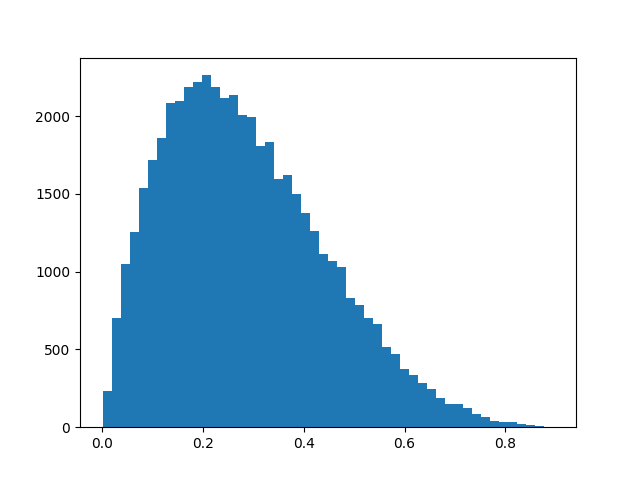

In [38]:
beta_sample = np.random.beta(2, 5, 50000)
print(np.mean(beta_sample), 2/7)

plt.figure()
plt.hist(beta_sample, bins=50)

In [ ]:
plt.close('all')
d = 1.0
N = 20000
alphas = np.arange(0.001, 2.000, 0.001)
x_mus = []
y_mus = []
x_stds = []
y_stds = []
for idx, alpha in enumerate(alphas):
    if idx%100 == 0:
        print(alpha)
    trajs_model, labels_model = models_phenom().single_state(N=N,
                                                            L=L,
                                                            T=16,
                                                            alphas=alpha,
                                                            Ds=[d, 0.0],
                                                             dim=3
                                                           )
    
    last_pos_sample = []
    for traj_nb in range(N):
        x = trajs_model[:, traj_nb, 0][:]
        y = trajs_model[:, traj_nb, 1][:]
        z = trajs_model[:, traj_nb, 2][:]
        
        
        rad = np.arctan((y[-2] - y[-3])/(x[-2] - x[-3]))
        rot_mat = np.array([[np.cos(-rad), -np.sin(-rad)], [np.sin(-rad), np.cos(-rad)]])
        
        x = x[-3:]
        y = y[-3:]
        x -= x[0]
        y -= y[0]
        z -= z[0]
        for i in range(len(x)):
            x[i], y[i] = rot_mat@np.array([[x[i]], [y[i]]])
    
        if x[-2] - x[-3] < 0:
            for i in range(len(x)):
                x[i] = -x[i]
        x_tmp = x[-2]
        y_tmp = y[-2]
        x -= x_tmp
        y -= y_tmp
    
        dis = abs(x[-3] - x[-2])
        x *= 1/dis
        y *= 1/dis
        
        last_pos_sample.append([x[-1], y[-1]])
    last_pos_sample = np.array(last_pos_sample)
    x_mus.append(np.mean(last_pos_sample[:, 0]))
    y_mus.append(np.mean(last_pos_sample[:, 1]))
    x_stds.append(np.std(last_pos_sample[:, 0]))
    y_stds.append(np.std(last_pos_sample[:, 1]))
x_mus = np.array(x_mus)
y_mus = np.array(y_mus)
x_stds = np.array(x_stds)
y_stds = np.array(y_stds)
print('-------------------------------')

/tmp/ipykernel_49709/149380984.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i], y[i] = rot_mat@np.array([[x[i]], [y[i]]])


In [ ]:
plt.figure()
plt.plot(alphas, x_mus)
plt.plot(alphas, y_mus)
plt.plot(alphas, x_stds)
plt.plot(alphas, y_stds)

mu_x:  -0.0004171738920106364 mu_y:  0.004460585483711816
std_x:  1.9085135024797666 std_y:  2.504312685484908


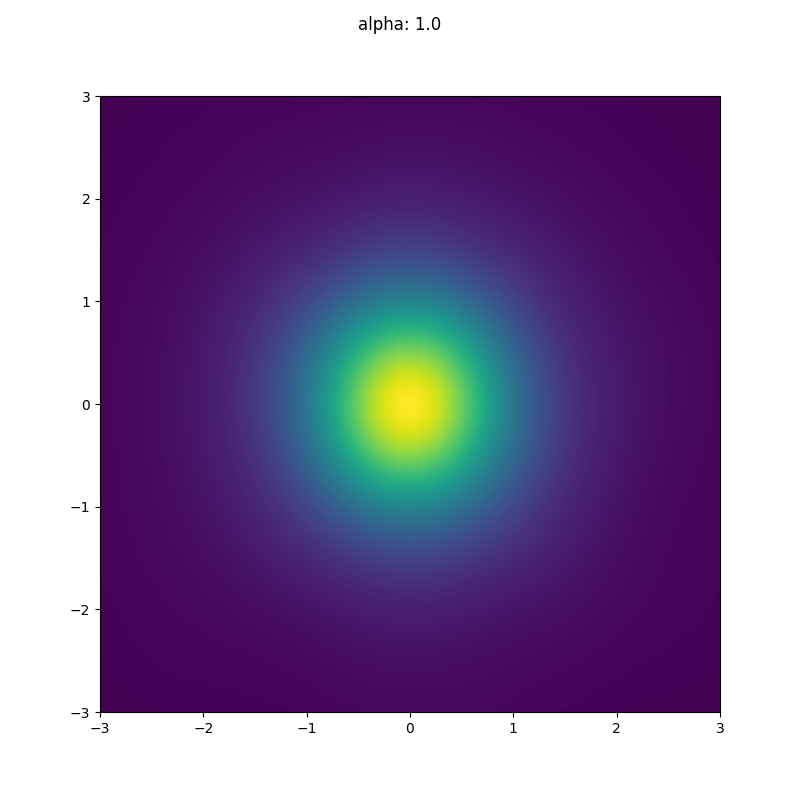

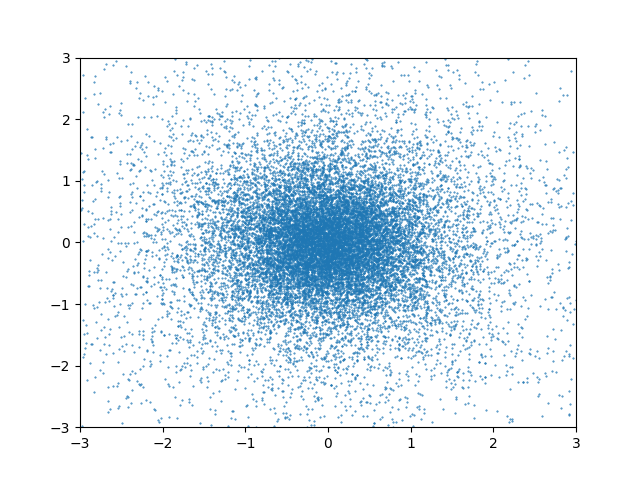

In [75]:
print('mu_x: ', np.mean(last_pos_sample[:, 0]), 'mu_y: ', np.mean(last_pos_sample[:, 1]))
print('std_x: ', np.std(last_pos_sample[:, 0]), 'std_y: ', np.std(last_pos_sample[:, 1]))
plt.close('all')
plt.figure()
plt.scatter(last_pos_sample[:, 0], last_pos_sample[:, 1], s=0.2)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
 
nbins = 1000
x = last_pos_sample[:, 0]
y = last_pos_sample[:, 1]

k = gaussian_kde([x,y])
xi, yi = np.mgrid[
   -3:3:nbins*1j,
   -3:3:nbins*1j
]
zi = k(np.vstack([
   xi.flatten(),
   yi.flatten()
])).reshape(xi.shape)
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle(f'alpha: {alpha}')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.pcolormesh(xi, yi, zi)
plt.show()

(array([1.152e+03, 1.172e+03, 1.097e+03, 1.101e+03, 1.152e+03, 1.071e+03,
        1.045e+03, 1.027e+03, 9.950e+02, 9.380e+02, 9.280e+02, 8.760e+02,
        8.040e+02, 7.230e+02, 6.990e+02, 6.330e+02, 6.120e+02, 5.630e+02,
        5.290e+02, 4.450e+02, 3.900e+02, 3.490e+02, 3.180e+02, 2.670e+02,
        2.350e+02, 2.200e+02, 1.930e+02, 1.550e+02, 1.430e+02, 1.250e+02,
        9.700e+01, 8.000e+01, 7.000e+01, 6.400e+01, 4.600e+01, 3.000e+01,
        2.700e+01, 1.700e+01, 1.400e+01, 2.800e+01, 8.000e+00, 8.000e+00,
        5.000e+00, 7.000e+00, 8.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.        , 0.09887598, 0.19775195, 0.29662793, 0.3955039 ,
        0.49437988, 0.59325585, 0.69213183, 0.7910078 , 0.88988378,
        0.98875975, 1.08763573, 1.1865117 , 1.28538768, 1.38426365,
        1.48313963, 1.58201561, 1.68089158, 1.77976756, 1.87864353,
        1.97751951, 2.07639548, 2.17527146, 2.27414743, 2.37302341,
        2.47189938, 2.57077536, 2.66

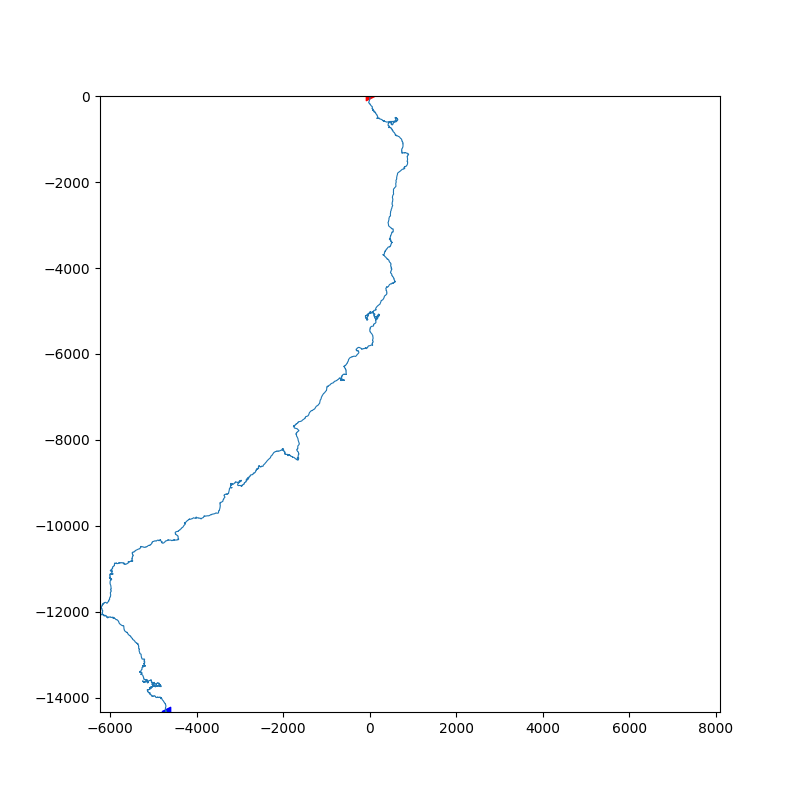

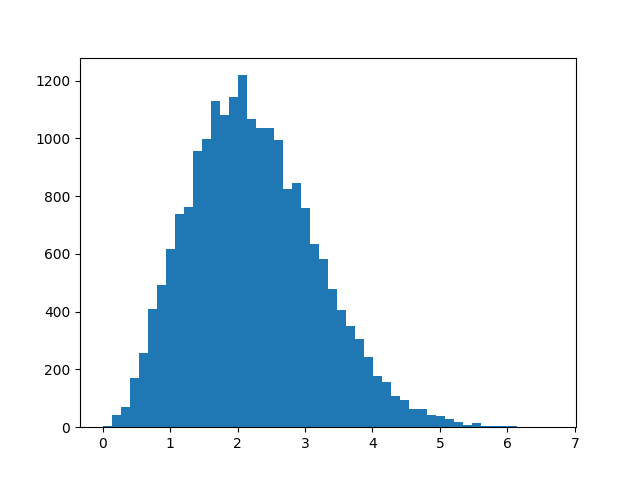

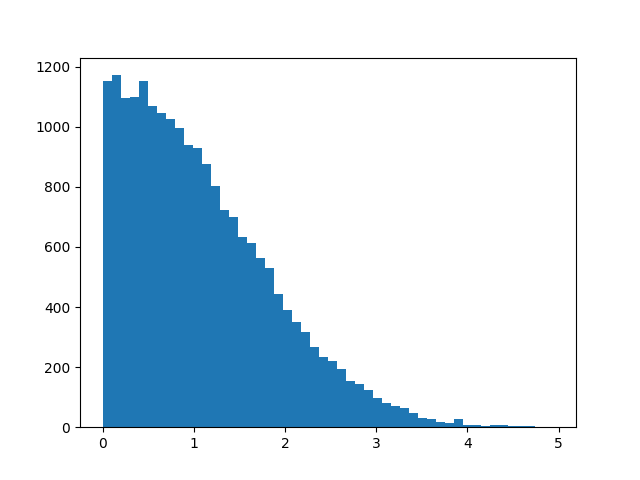

In [13]:
plt.close('all')
alpha = 1.8
d = 1.0
trajs_model, labels_model = models_phenom().single_state(N=2,
                                                        L=L,
                                                        T=20480,
                                                        alphas=alpha,
                                                        Ds=[d, 0.0],
                                                         dim=3
                                                       )

x = trajs_model[:, 0, 0][:]
y = trajs_model[:, 0, 1][:]
z = trajs_model[:, 0, 2][:]
x -= x[0]
y -= y[0]
z -= z[0]

plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
x_uncum = uncumulate(x)
y_uncum = uncumulate(y)
z_uncum = uncumulate(z)
jump_ds = np.sqrt(x_uncum**2 + y_uncum**2 + z_uncum**2)
#print(x)
#print(y)
#plt.figure()
#plt.hist(x_uncum)
#plt.figure()
#plt.hist(y_uncum)
plt.figure()
plt.hist(jump_ds, bins=50)


In [7]:
sliced_signals = signal_from_extended_data(x, y, WIN_WIDTHS, EXT_WIDTH, 1, SHIFT_WIDTH)
slice_norm_signal = slice_normalize(sliced_signals)
signals = slice_norm_signal
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]
print(f'GT: {changepoints}')

GT: [2]


In [169]:
plt.close('all')
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]


for idx in range(signals.shape[0]):
    plt.figure(f'signal_{idx}')
    plt.plot(np.arange(signals.shape[0])[:idx], signals[:idx], c='red')
    for cp in changepoints:
        plt.vlines(cp, 0, 1, color='blue')
    plt.ylim([0, 1])
    plt.xlim([-5, signals.shape[0]+5])
    plt.savefig(f'./figs/signal_{idx}.png')

    plt.figure(f'trj_2d_{idx}', figsize=(8, 8))
    plt.plot(x, y, linewidth=0.8)
    plt.scatter(x[idx], y[idx], marker='o', c='red')
    plt.xlim([np.min(x) - 2,
                      np.min(x) + max(np.max(x) - np.min(x), 
                        np.max(y) - np.min(y)) + 2])
    plt.ylim([np.min(y) - 2,
                      np.min(y) + max(np.max(x) - np.min(x), 
                        np.max(y) - np.min(y)) + 2])
    plt.scatter(x[0], y[0], marker='>', c='red')
    plt.scatter(x[-1], y[-1], marker='<', c='blue')
    for cp in changepoints:
        plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)
    plt.savefig(f'./figs/trj_2d_{idx}.png')
    
    plt.figure(f'trj_3d_{idx}', figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.plot3D(x, y, np.arange(signals.shape[0]), linewidth=0.8, alpha=0.7)
    ax.set_xlim([np.min(x) - 2,
                      np.min(x) + max(np.max(x) - np.min(x), 
                        np.max(y) - np.min(y)) + 2])
    ax.set_ylim([np.min(y) - 2,
                      np.min(y) + max(np.max(x) - np.min(x), 
                        np.max(y) - np.min(y)) + 2])
    ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
    ax.scatter3D(x[-1], y[-1], signals.shape[0], marker='<', c='blue')

    for cp in changepoints:
        ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[0])[cp], marker='+', c='blue', zorder=2)
    ax.scatter3D(x[idx], y[idx], np.arange(signals.shape[0])[idx], marker='o', c='red')
    plt.savefig(f'./figs/trj_3d_{idx}.png')
plt.close('all')

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_6250/1203604448.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(f'trj_3d_{idx}', figsize=(8, 8))


In [170]:
filenames=[f'./figs/signal_{idx}.png' for idx in range(signals.shape[0])]
import imageio
with imageio.get_writer('./figs/signal.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
filenames=[f'./figs/trj_2d_{idx}.png' for idx in range(signals.shape[0])]
import imageio
with imageio.get_writer('./figs/traj_2d.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
filenames=[f'./figs/trj_3d_{idx}.png' for idx in range(signals.shape[0])]
import imageio
with imageio.get_writer('./figs/traj_3d.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_6250/2035855518.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_6250/2035855518.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_6250/2035855518.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import